# Annotate physicochemical properties for NTD drugs

### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors

### Load data

In [2]:
df = pd.read_csv("../data/ntd_drugs.tsv", sep="\t")
df.head(2)

,chembl_id,pref_name,canonical_smiles,standard_inchi,standard_inchi_key,max_phase,indication_class,withdrawn_flag,black_box_warning,drugind_id,max_phase_for_ind,mesh_id,mesh_heading,ref_type,ref_id,ref_url
0,CHEMBL1200689,NITRIC OXIDE,[N]=O,InChI=1S/NO/c1-2,MWUXSHHQAYIFBG-UHFFFAOYSA-N,4.0,NaN,0,0,23580,3.0,D016773,"Leishmaniasis, Cutaneous",ClinicalTrials,NCT00317629,https://clinicaltrials.gov/ct2/results?id=%22N...
1,CHEMBL131,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,4.0,Glucocorticoid,0,0,24801,2.0,D007918,Leprosy,ClinicalTrials,"NCT00919542,NCT00919776,NCT00919815",https://clinicaltrials.gov/ct2/results?id=%22N...


### Calculate chemphys properties

In [3]:
df = df[["chembl_id", "pref_name", "canonical_smiles"]]
df.drop_duplicates(inplace=True)

In [4]:
chemphys_data = []

for idx, name, smiles in tqdm(df.values):

    # Desalting step
    if "." in smiles:
        all_smiles = smiles.split(".")
        smiles = sorted(all_smiles, key=len)[0]

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        continue

    mw = Descriptors.ExactMolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    rot_bonds = Descriptors.NumRotatableBonds(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    heavy_atoms = mol.GetNumHeavyAtoms()

    chemphys_data.append(
        {
            "chembl_id": idx,
            "pref_name": name,
            "canonical_smiles": smiles,
            "MW (Da)": mw,
            "ALogP": logp,
            "Rotatable bonds": rot_bonds,
            "TPSA": tpsa,
            "HBD": hbd,
            "HBA": hba,
            "HAC": heavy_atoms,
        }
    )

chemphys_df = pd.DataFrame(chemphys_data)

100%|██████████| 46/46 [00:00<00:00, 375.31it/s]


In [5]:
chemphys_df.head(2)

,chembl_id,pref_name,canonical_smiles,MW (Da),ALogP,Rotatable bonds,TPSA,HBD,HBA,HAC
0,CHEMBL1200689,NITRIC OXIDE,[N]=O,29.997989,-0.4471,0,39.37,0,1,2
1,CHEMBL131,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,360.193674,1.5576,2,94.83,3,5,26


In [6]:
chemphys_df.to_csv("../data/ntd_drugs_chemphys.tsv", sep="\t", index=False)

# Physicochemical exploration

<Axes: title={'center': 'Molecular Weight (Da)'}, ylabel='Frequency'>

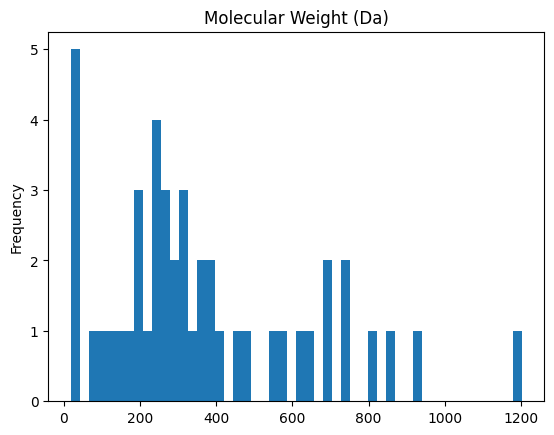

In [7]:
chemphys_df["MW (Da)"] = chemphys_df["MW (Da)"].round(2)
chemphys_df["MW (Da)"].plot(kind="hist", bins=50, title="Molecular Weight (Da)")

In [8]:
chemphys_df["MW (Da)"].mean(), chemphys_df["MW (Da)"].std()

(372.3495652173913, 271.0981028742713)

In [9]:
chemphys_df.sort_values(by=["MW (Da)"], ascending=False).head(5)

,chembl_id,pref_name,canonical_smiles,MW (Da),ALogP,Rotatable bonds,TPSA,HBD,HBA,HAC
2,CHEMBL160,CYCLOSPORINE,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,1201.84,3.26900,15,278.80,5,12,85
7,CHEMBL267345,AMPHOTERICIN B,C[C@@H]1[C@H](O)[C@@H](C)/C=C/C=C/C=C/C=C/C=C/...,923.49,0.71170,3,319.61,12,17,65
12,CHEMBL1200633,IVERMECTIN,CO[C@H]1C[C@H](O[C@H]2[C@H](C)O[C@@H](O[C@@H]3...,860.49,5.21130,7,170.06,3,14,61
10,CHEMBL374478,RIFAMPIN,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,822.41,4.33542,4,220.15,6,15,59
13,CHEMBL529,AZITHROMYCIN,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,748.51,1.90070,7,180.08,5,14,52
